This notebook was used to train a "professional" versus "amateur" image classifier.

The classifier was created to try to circumvent hand labeling the quality of AptDeco images.  
Subjectively, the model performs well, but it was hard to quantitatively validate the model
since the training set is not an accurate representation of the use case.  The final classifier, uses a hand labeled dataset of AptDeco images instead of this classifier.

In [1]:
#Getting path to ImageFeatures Library
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from sklearn import linear_model
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import linear_model,ensemble,metrics,preprocessing
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import cv2
from ImageFeatures import *

/Users/richardknoche/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/richardknoche/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


In [2]:
#Get "amateur" photos
ama_df = pd.read_csv('/Users/richardknoche/DecoRater/AptDecoData/AllImages.csv')
ama_df.drop('Unnamed: 0',axis=1,inplace=True)
ama_df = ama_df.dropna()

#Select unedited, non-front page images
ama_df_all = ama_df
ama_df=ama_df[ (ama_df['frac_white']<0.001) & (ama_df['is_main']==False)]

ama_df['is_prof']=0

/Users/richardknoche/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
#Get professional photos
prof_df = pd.read_csv("/Users/richardknoche/DecoRater/AptDecoData/ProfessionalImageFeatures.csv")
prof_df.drop('Unnamed: 0',axis=1,inplace=True)
prof_df = prof_df.dropna()
prof_df['is_prof']=1

In [4]:
#Combine the two dataframe
features = ['Horizontal_Saturation_Sym', 'Thirds_To_Focal_Distance',
       'Vertical_Value_Sym', 'Salient_Saturation',
       'S_var', 'Thirds_Value', 'V_var', 'FFT_Sharpness', 'R_Mean', 'g_ygrad',
       'Thirds_Vertical_Value_Sym', 'Thirds_Sat', 'b_xgrad_std', 'g_xgrad_std',
       'Thirds_Horizontal_Saliency_Sym', 'Thirds_Saliency', 'G_Mean',
       'Salient_Hue', 'Histogram_Darkness', 'r_ygrad_std', 'Colorfulness',
       'Vertical_Saturation_Sym', 'G_Width', 'H_mean',
       'Thirds_Vertical_Saliency_Sym', 'Thirds_Vertical_Saturation_Sym',
       'r_xgrad_std', 'Lapacian_Saturation', 'Horizontal_Hue_Sym', 'b_ygrad',
       'B_Width', 'g_ygrad_std', 'r_ygrad', 'percieved_luminace',
       'Salient_Value', 'V_mean', 'Thirds_Horizontal_Saturation_Sym',
       'Number_of_Contours', 'Lapacian_Value', 'Complimentary_Color_Level',
       'Vertical_Hue_Sym', 'R_xgrad', 'H_var', 'Horizontal_Value_Sym',
       'Thirds_Horizontal_Value_Sym', 'b_ygrad_std', 'Thirds_Hue', 'g_xgrad',
       'S_mean', 'Laplacian_Sharpness', 'Busyness', 'Thirds_Vertical_Hue_Sym',
       'Lapacian_Hue', 'B_Mean', 'b_xgrad', 'standard_luminance',
       'Thirds_Horizontal_Hue_Sym', 'R_Width']

In [5]:
df=pd.concat([ama_df[features +['is_prof','product_id','is_main','path']],prof_df[features +['is_prof','path']]]).reset_index()

In [6]:
#Randomize the data
df = df.sample(frac=1,random_state=102)

In [7]:
col_to_predict = 'is_prof'

num_minority = min(len(df[df[col_to_predict]==False]),len(df[df[col_to_predict]==True]))
num_majority = max(len(df[df[col_to_predict]==False]),len(df[df[col_to_predict]==True]))

#Splitting into sub data frames
true_df  = df[df[col_to_predict]==True]
false_df = df[df[col_to_predict]==False]

#Downsampling to make training set
train_true  = true_df.sample(n=np.floor(num_minority*0.6),random_state = 102)
train_false = false_df.sample(n=np.floor(num_minority*0.6),random_state = 102) #Using 2*num_minority, since we supliment later
train = pd.concat([train_true,train_false])

#Making test set with accurate ratio of high to low quality
test  = df.drop(train.index)
test1 = test[test[col_to_predict]==1]
test2 = test[test[col_to_predict]==0].sample(n=np.floor(len(test1)*num_majority/num_minority),random_state=50)
test  = pd.concat([test1,test2])

#Use 50% of test set as CV set
cv = test.sample(frac=0.5,random_state=102)
test = test.drop(cv.index)

/Users/richardknoche/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  locs = rs.choice(axis_length, size=n, replace=replace, p=weights)


# Train Classifier

In [8]:
#Setting up x and y data for the model
train_x = train[features]
train_y = train[col_to_predict]

test_x = test[features]
test_y = test[col_to_predict]

cv_x = cv[features]
cv_y = cv[col_to_predict]

In [9]:
#Making a function for evaluating the model
def EvaluateModel(x,y):
    
    #Get predictions and probabilities
    predicted_y = clf.predict(x)
    y_probs =clf.predict_proba(x)[:, 1]

    #Make ROC
    fpr, tpr, thresholds = metrics.roc_curve(y, y_probs)
    sns.set_style("whitegrid")
    blue, = sns.color_palette("muted", 1)
    fig = plt.figure(figsize=(20,14))
    ax = plt.gca()
    ax.plot(fpr, tpr, color=blue, lw=3)
    ax.fill_between(fpr, 0, tpr, alpha=.3)
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlabel('False positive rate',size=60)
    ax.set_ylabel('True positive rate',size=60)
    ax.set_title('ROC Curve',size=60)
    ax.set_xticklabels(np.linspace(0,1,6),size=50)
    ax.set_yticklabels(np.linspace(0,1,6),size=50)
    ax.text(0.8,0.1,"AUC: %0.2f" % metrics.auc(fpr, tpr),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=0.5'),size=50)


    #Accuracy, Precision, Recall
    print('Accuracy: ',clf.score(x,y))
    f1score, tpr, thresholds = metrics.roc_curve(y, y_probs)

    precision, recall, thresholds = precision_recall_curve(y,y_probs)
    average_precision = average_precision_score(y, y_probs)
    print(average_precision)


    #Prec-Recall Curve
    fig = plt.figure(figsize=(20,14))
    ax = plt.gca()
    ax.plot(recall, precision, color=blue, lw=3)
    ax.fill_between(recall, 0, precision, alpha=.3)
    ax.set_xlabel('Recall',size=60)
    ax.set_ylabel('Precision',size=60)
    ax.set_title('PR Curve',size=60)
    ax.set_xticklabels(np.linspace(0,1,6),size=50)
    ax.set_yticklabels(np.linspace(0,1,6),size=50)


    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y, predicted_y)
    classifier_metrics = pd.DataFrame( {'Precision' : precision, 'Recall' : recall, 'F-Score' : fscore, 'Support' : support})
    classifier_metrics.index=['Bad','Good']

    import pylab as pl
    labels = ['Low Quality', 'High Quality']

    cm = metrics.confusion_matrix(y, predicted_y)
    cm = (cm[0]/np.sum(cm[0]),cm[1]/np.sum(cm[1]))


    fig = plt.figure(figsize=(20,14))
    ax = plt.gca()
    ax.grid(False)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm,cmap='Blues')
    pl.title('Confusion Matrix',size=60)
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel('Percentage',size=60)
    cbar.ax.tick_params(labelsize=50) 
    ax.set_xticklabels([''] + labels,size=50)
    ax.set_yticklabels([''] + labels,size=50)
    ax.xaxis.set_ticks_position('bottom')
    pl.xlabel('Predicted',size=60)
    pl.ylabel('True',size=60)

    pl.text(0,0,'Neg Frac \n Correct: %.2f'% cm[0][0],va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'),size=30)
    pl.text(0,1,'Pos Frac \n Wrong: %.2f'% cm[1][0],va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'),size=30)
    pl.text(1,0,'Neg Frac \n Wrong: %.2f'% cm[0][1],va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'),size=30)
    pl.text(1,1,'Pos Frac \n Correct: %.2f'% cm[1][1],va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'),size=30)
    pl.show()
    
    print(classifier_metrics.head())

Accuracy:  0.970515833054
0.995041862938


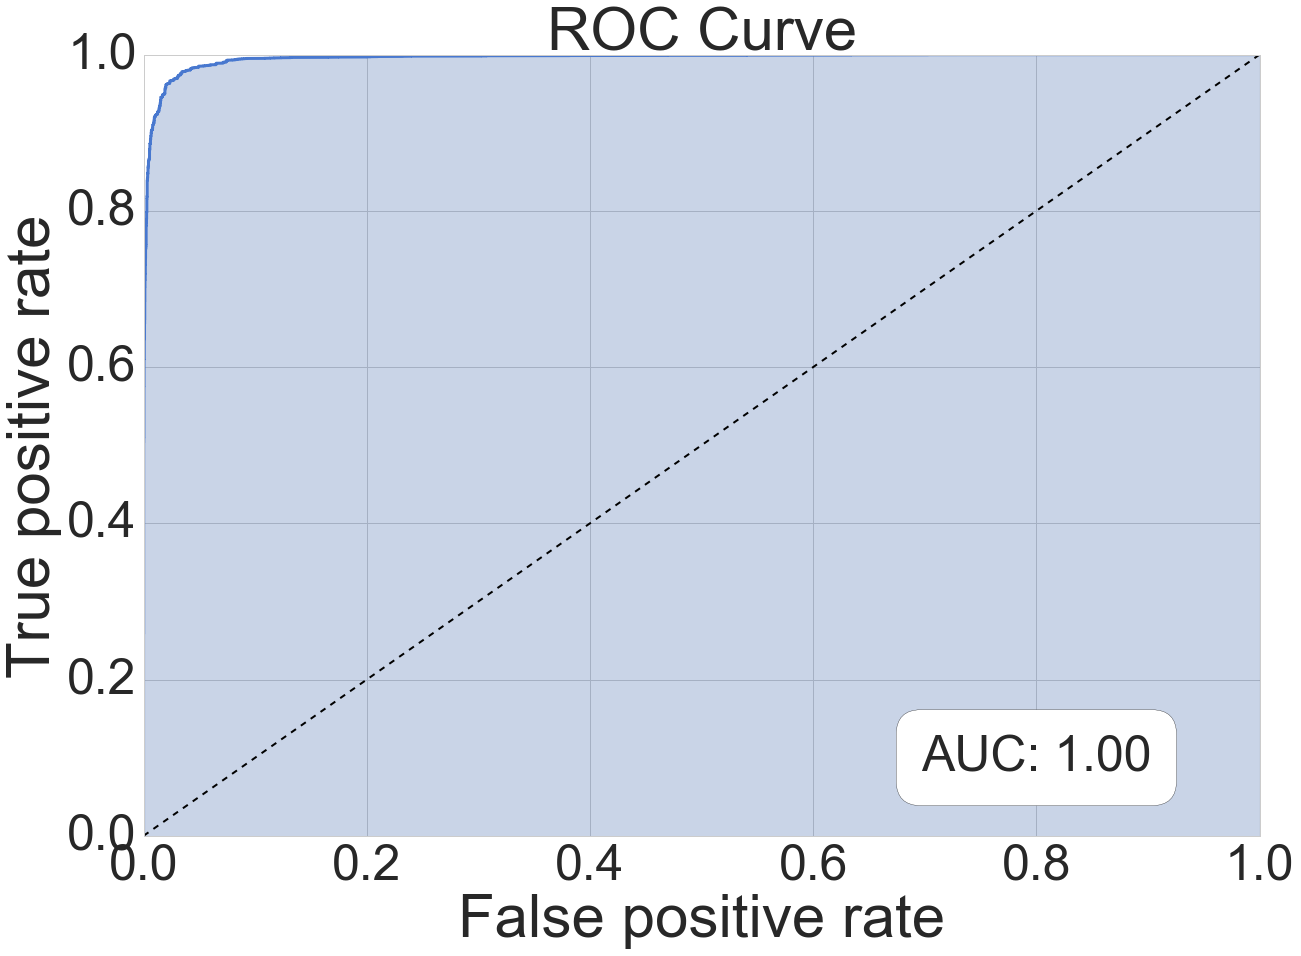

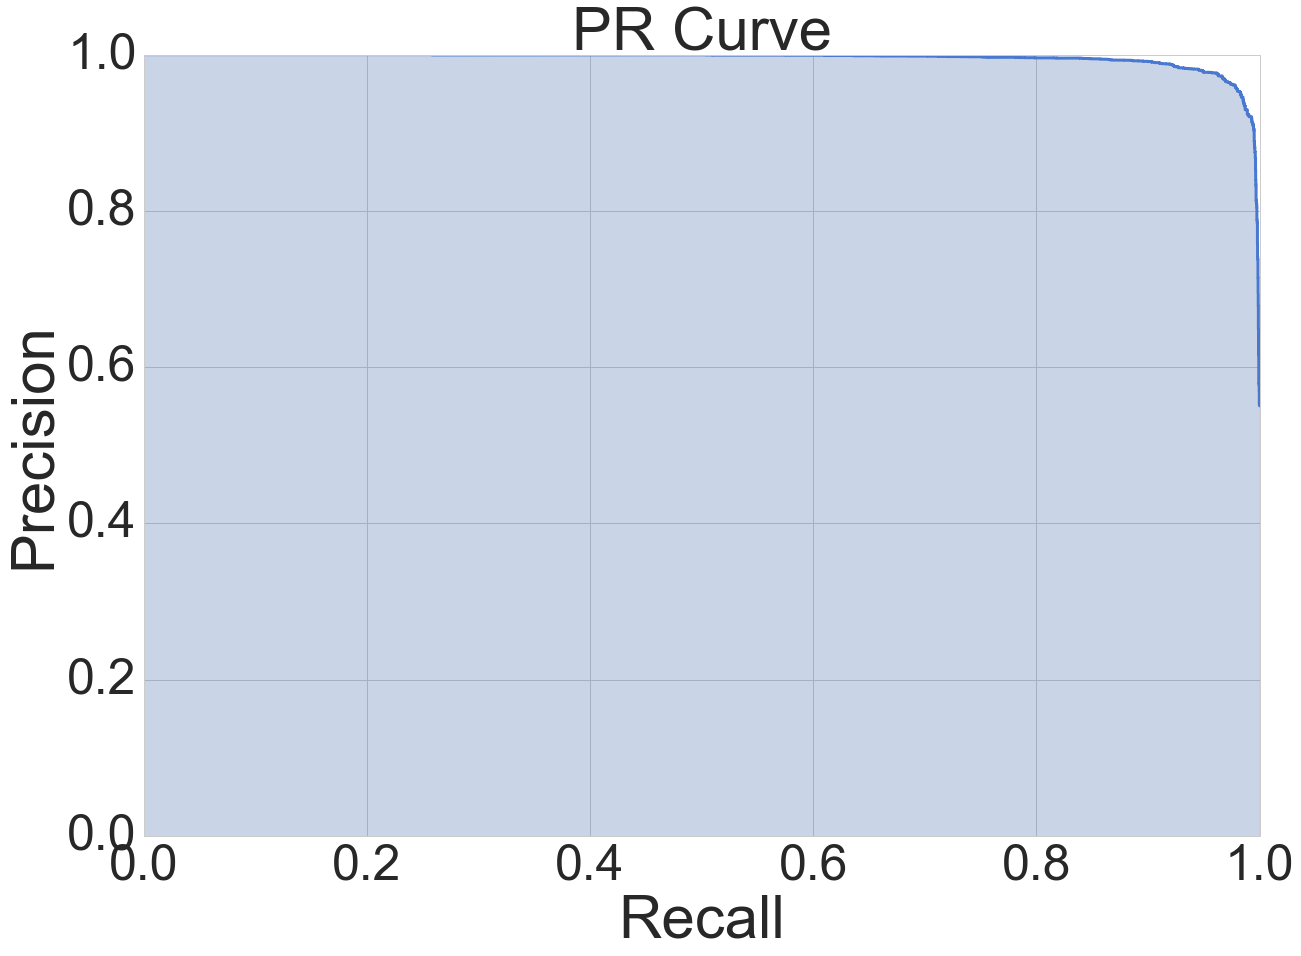

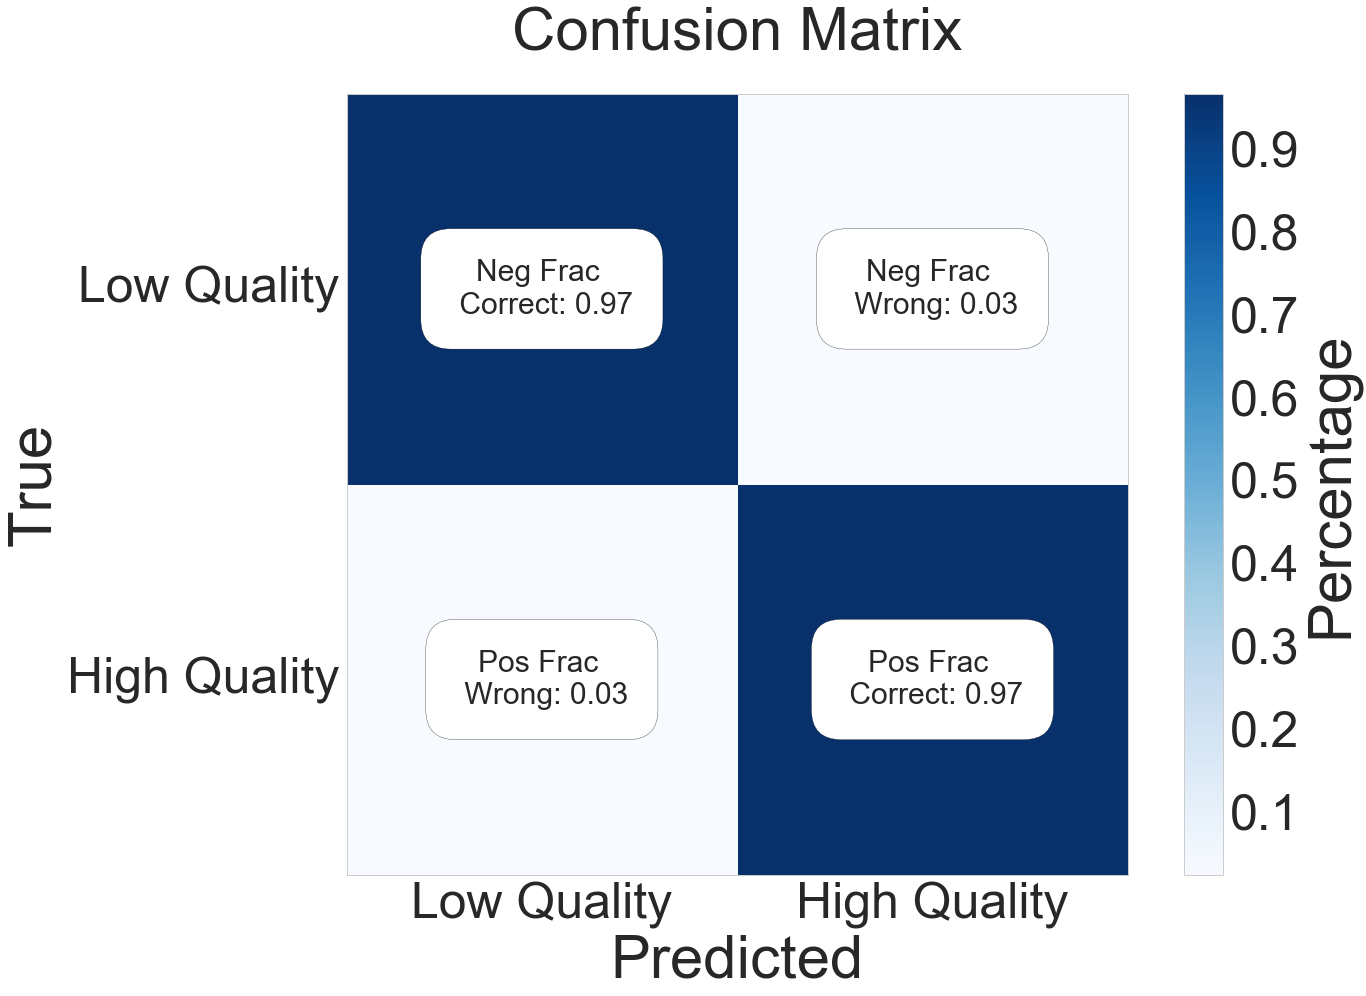

       F-Score  Precision    Recall  Support
Bad   0.972453   0.973216  0.971691     9573
Good  0.968285   0.967412  0.969160     8301


In [10]:
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
import seaborn as sns


#Train Model
clf = ensemble.AdaBoostClassifier() 
clf.fit(train_x,train_y)

#Evaluate on CV set while tuning
EvaluateModel(cv_x,cv_y)

# Save the classifier

In [ ]:
import pickle
save = False
if save == True:
    with open('image_classifier.pkl', 'wb') as f:
        pickle.dump(clf, f)

    with open('image_classifier_features.pkl', 'wb') as f:
        pickle.dump(features, f)

# Evaluate the model

Accuracy:  0.968445787177
0.994978857463


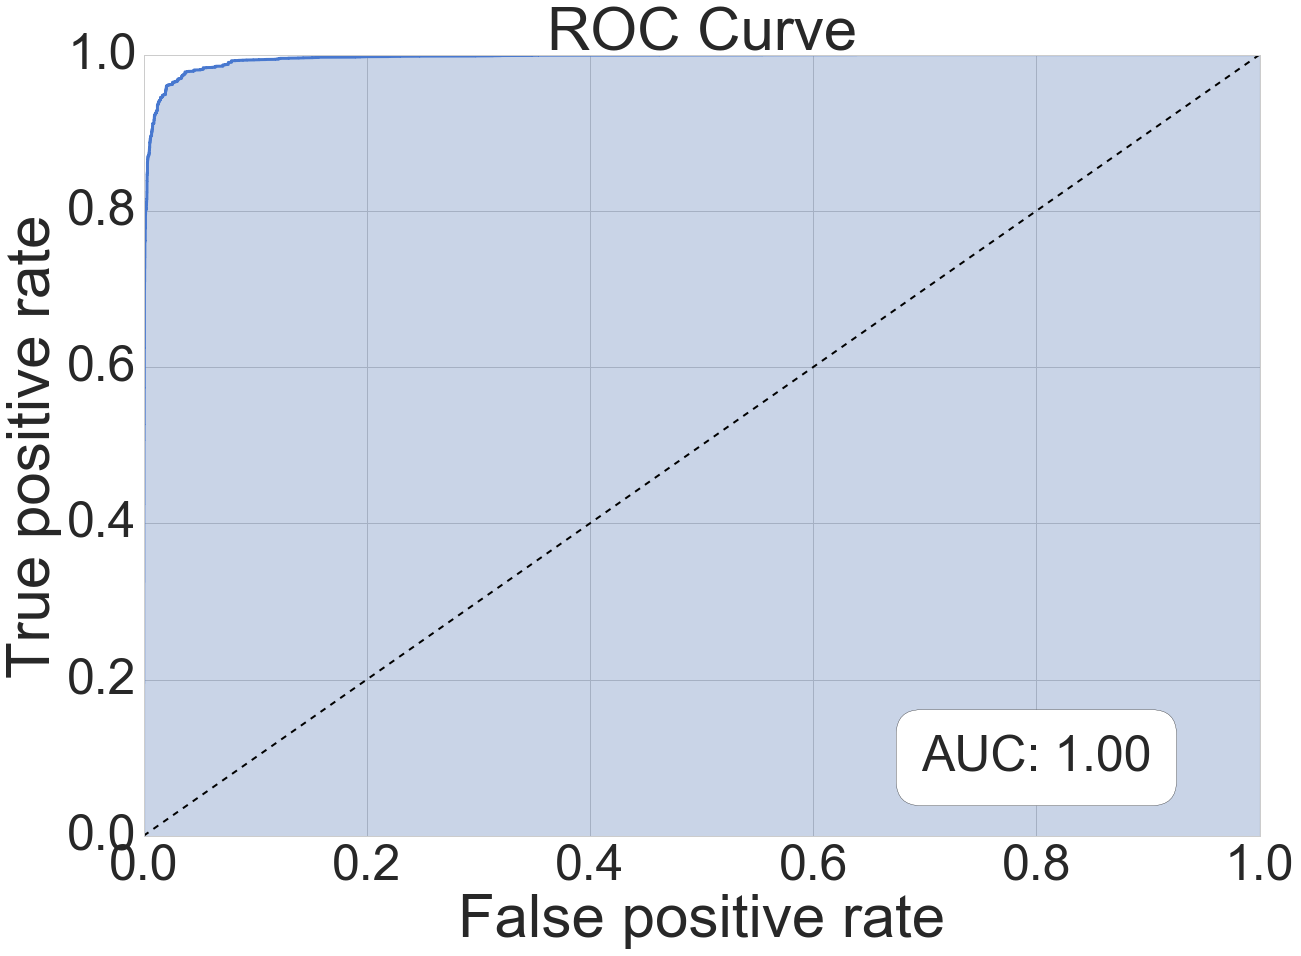

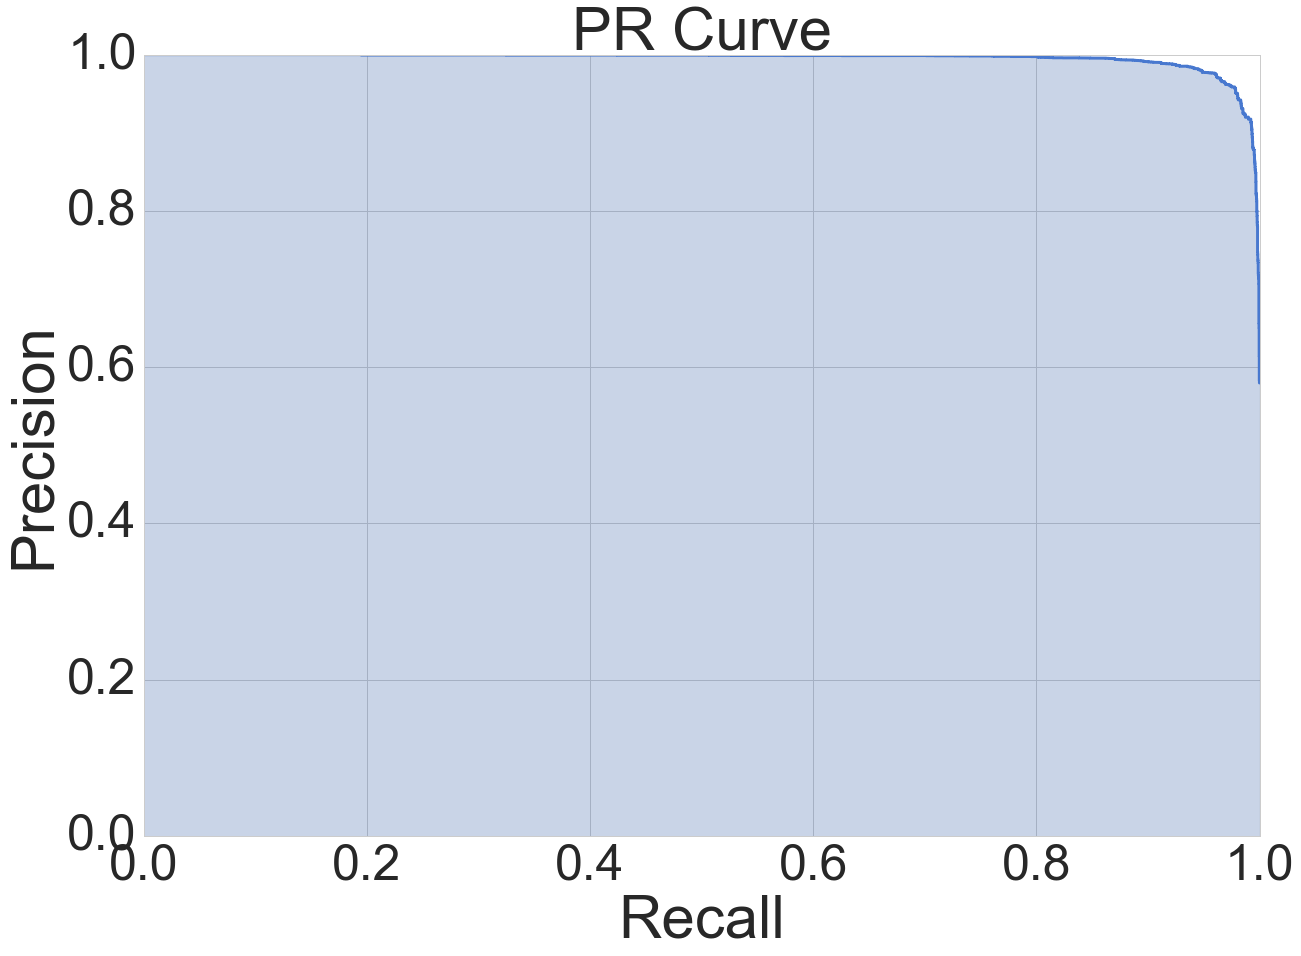

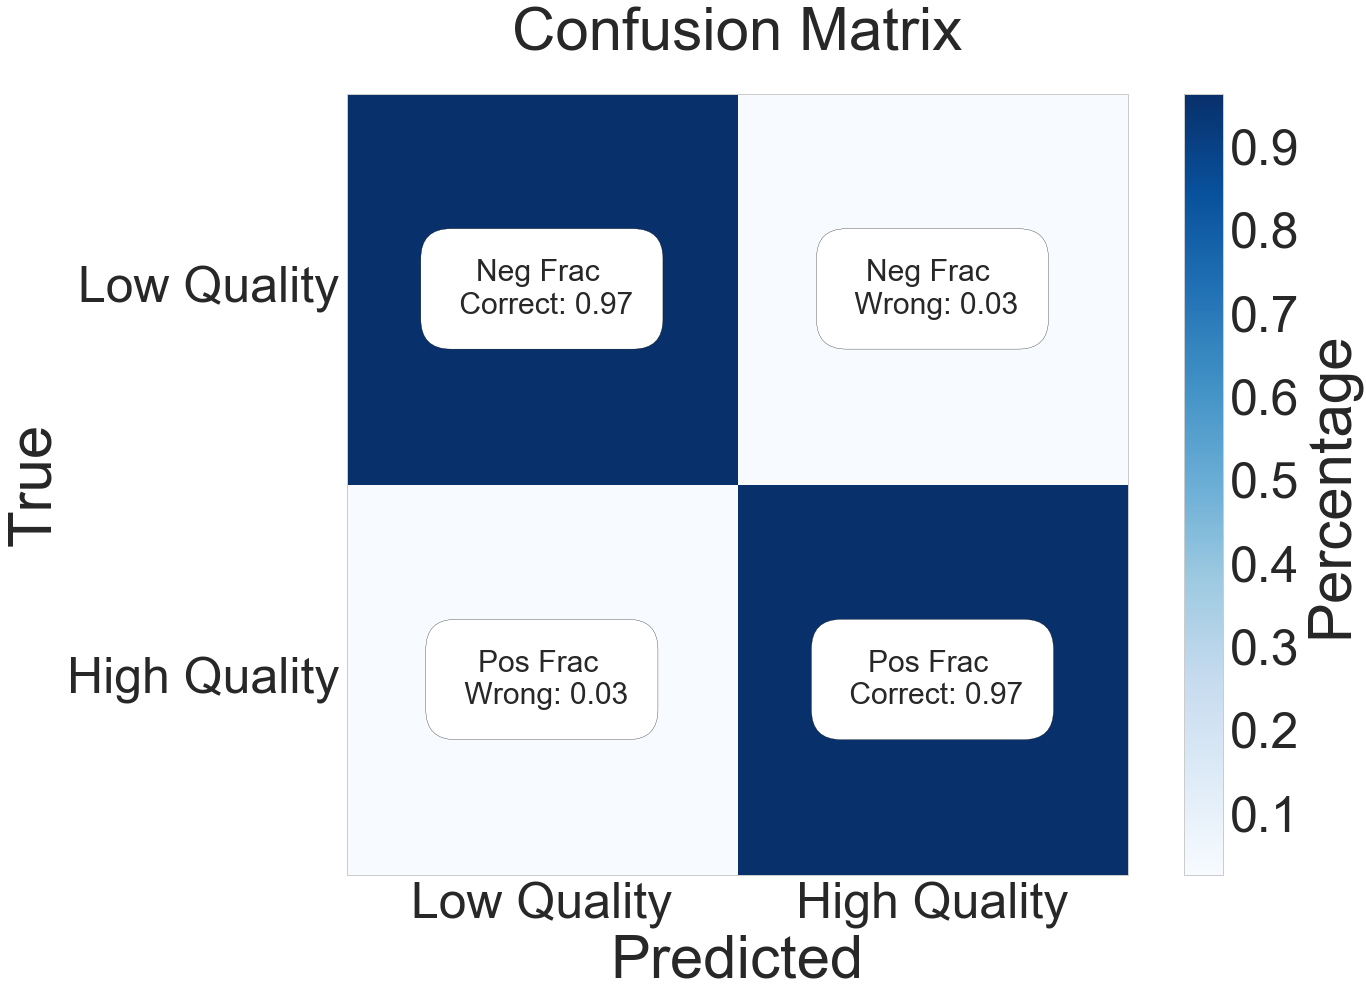

       F-Score  Precision    Recall  Support
Bad   0.970250   0.972404  0.968105     9500
Good  0.966409   0.963997  0.968832     8374


In [12]:
EvaluateModel(test_x,test_y)

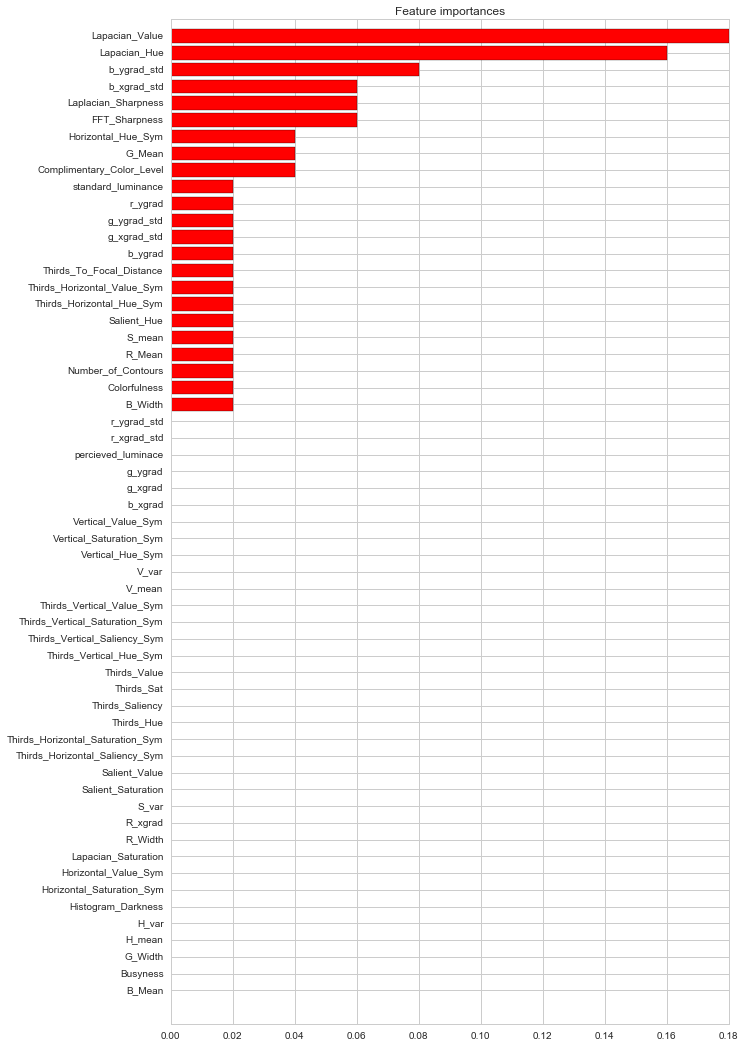

In [13]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]


sorted_importances = [importance for (importance,feature) in sorted(zip(importances,features),reverse=True)]
sorted_features = [feature for (importance,feature) in sorted(zip(importances,features),reverse=True)]   
    
plt.figure(figsize=(10,18))
plt.title("Feature importances")
plt.barh(range(len(sorted_features),0,-1), sorted_importances,
       color="r", align="center")
plt.yticks(range(len(sorted_features),0,-1))
ax=plt.gca()
ax.set_yticklabels(sorted_features)
plt.ylim([-1, len(sorted_features)+1])
plt.show()

# Showing how the model generalizes to Amateur AptDeco images.

In [14]:
def CalcProb(row):
    row['IsProf_Prob'] = clf.predict_proba(df.ix[0,features])



In [15]:
df['PredictedClass']=clf.predict(df[features])
df['IsProf_Prob']=clf.predict_proba(df[features])[:,1]

ama_df_all['PredictedClass']=clf.predict(ama_df_all[features])
ama_df_all['IsProf_Prob']=clf.predict_proba(ama_df_all[features])[:,1]


ama_df['PredictedClass']=clf.predict(ama_df[features])
ama_df['IsProf_Prob']=clf.predict_proba(ama_df[features])[:,1]


/Users/richardknoche/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/richardknoche/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[  4.73555855e-01   1.27751330e-02   2.95585114e+03   5.25455113e-01
   1.35325257e-02   2.46853093e+03] 
 [  4.07451158e-04   4.28932126e-04   7.84778488e+01   5.01040121e-04
   5.34666526e-04   7.66062900e+01]


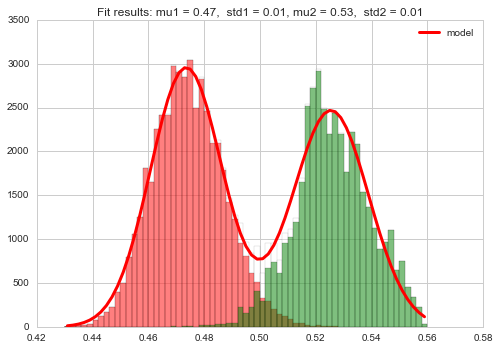

In [16]:
from pylab import *
from scipy.optimize import curve_fit

bins=np.arange(0.43,0.56,0.002)

# Plot the histogram.
y,x,_ = plt.hist(df['IsProf_Prob'],bins=bins, normed=False, alpha=.3, color=[1,1,1])
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected=(0.47,.04,3000,0.53,.04,3000)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))
plot(x,bimodal(x,*params),color='red',lw=3,label='model')
legend()
print(params,'\n',sigma)    

title = "Fit results: mu1 = %.2f,  std1 = %.2f, mu2 = %.2f,  std2 = %.2f" % (params[0],params[1],params[3],params[4])
plt.title(title)
_,_,_ = plt.hist(df[df['is_prof']==False]['IsProf_Prob'],bins=bins,alpha=0.5,color='r')
_,_,_ = plt.hist(df[df['is_prof']==True]['IsProf_Prob'],bins=bins,alpha=0.5,color='g')

plt.show()